In [1]:
%%bash
nvidia-smi
echo "Number of workers: $(nproc)"

Mon Dec 15 20:27:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import time
import copy
import warnings
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [3]:
class Config:
   
    # Data
    data_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data"
   
    # Model
    model_name = 'vit_b_16'
    num_classes = 196
    img_size = 224
   
    # Training
    batch_size = 64
   
    epochs = 30
    num_workers = 4
    seed = 42
   
    # Optimizer & Learning Rates (Differential)
    lr_backbone = 1e-5
    lr_head = 3e-4
    min_lr = 1e-7
   
    weight_decay = 0.05
    warmup_epochs = 3
   
    # System
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(Config.seed)
torch.backends.cudnn.benchmark = True

In [4]:
def build_dataloaders(Config: Config) -> Tuple[DataLoader, DataLoader, DataLoader, int]:
    
    # Train Transform
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(Config.img_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
    ])
   
    # Validation/Test Transform
    eval_transform = transforms.Compose([
        transforms.Resize(int(Config.img_size * 1.14), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(Config.img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
   
    # Load datasets
    train_dataset = datasets.ImageFolder(os.path.join(Config.data_dir, 'train'), transform=train_transform)
    full_test_dataset = datasets.ImageFolder(os.path.join(Config.data_dir, 'test'), transform=eval_transform)
   
    targets = full_test_dataset.targets
    train_idx, test_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.5,
        shuffle=True,
        stratify=targets,
        random_state=Config.seed
    )
   
    val_dataset = Subset(full_test_dataset, train_idx)
    test_dataset = Subset(full_test_dataset, test_idx)
   
    print(f"Data Split -> Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
   
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.batch_size,
        shuffle=True,
        num_workers=Config.num_workers,
        pin_memory=True,
        drop_last=True
    )
   
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers,
        pin_memory=True
    )
   
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.batch_size,
        shuffle=False,
        num_workers=Config.num_workers,
        pin_memory=True
    )
   
    return train_loader, val_loader, test_loader, len(train_dataset.classes)

In [5]:
def build_optimizer(model, config):
    
    # Full Fine-tuning
    for param in model.parameters():
        param.requires_grad = True

    head_params = []
    backbone_params = []
   
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if 'head' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
           
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': config.lr_backbone},
        {'params': head_params, 'lr': config.lr_head}
    ], weight_decay=config.weight_decay)
   
    return optimizer

In [6]:
class Trainer:
   
    def __init__(self, model, train_loader, val_loader, test_loader):
        self.model = model.to(Config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = build_optimizer(self.model, Config)
       
        # Scheduler: warmup + cosine annealing
        steps_per_epoch = len(train_loader)
        total_steps = Config.epochs * steps_per_epoch
        warmup_steps = Config.warmup_epochs * steps_per_epoch
       
        scheduler1 = LinearLR(self.optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
        scheduler2 = CosineAnnealingLR(self.optimizer, T_max=total_steps - warmup_steps, eta_min=Config.min_lr)
       
        self.scheduler = SequentialLR(self.optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_steps])
       
        self.criterion = nn.CrossEntropyLoss()
       
        self.best_val_acc = 0.0
        self.history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
   
    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        num_steps = len(self.train_loader)
       
        for i, (images, targets) in enumerate(self.train_loader):
            images, targets = images.to(Config.device), targets.to(Config.device)
           
            self.optimizer.zero_grad()
           
            # Forward
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
           
            # Backward
            loss.backward()
           
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
           
            # Optimizer & scheduler step
            self.optimizer.step()
            self.scheduler.step()
           
            # Metrics
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)
            total_loss += loss.item()
           
            if i % 50 == 0:
                current_lr = self.optimizer.param_groups[1]['lr']
                print(f"Epoch [{epoch+1}][{i}/{num_steps}] Loss: {loss.item():.4f} LR: {current_lr:.6f}")
   
        avg_loss = total_loss / num_steps
        avg_acc = 100 * correct / total_samples
        return avg_loss, avg_acc
   
    @torch.no_grad()
    def evaluate(self, loader, desc="Validation"):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
       
        for images, targets in loader:
            images, targets = images.to(Config.device), targets.to(Config.device)
           
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
           
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
           
        avg_loss = total_loss / len(loader)
        acc = 100 * correct / total
        print(f"--- {desc} Loss: {avg_loss:.4f} | Acc: {acc:.2f}% ---")
        return avg_loss, acc
   
    @torch.no_grad()
    def get_predictions(self):
        self.model.eval()
        all_preds, all_targets, all_probs = [], [], []
       
        for images, targets in self.test_loader:
            images = images.to(Config.device)
            outputs = self.model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
           
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
            all_probs.extend(probs.cpu().numpy())
           
        return np.array(all_targets), np.array(all_preds), np.array(all_probs)
   
    def run(self):
        print(f"Starting full fine-tuning on {Config.device}...")
        start_time = time.time()
       
        for epoch in range(Config.epochs):
            train_loss, train_acc = self.train_one_epoch(epoch)
            val_loss, val_acc = self.evaluate(self.val_loader, desc="Val")
           
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
           
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), "best_vit_stanford_cars.pth")
                print(f">>> New Best Model Saved! Acc: {val_acc:.2f}%")
   
        print(f"Training Complete. Total time: {(time.time() - start_time)/60:.1f} mins")
        return self.history

In [7]:
class Visualizer:
   
    def __init__(self, save_dir="plots"):
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        
    def plot_history(self, history):
        epochs = range(1, len(history['train_loss']) + 1)
       
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
       
        ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        ax1.plot(epochs, history['val_loss'], 'r--', label='Val Loss')
        ax1.set_title('Loss: Train vs Val')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
       
        ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
        ax2.plot(epochs, history['val_acc'], 'g--', label='Val Acc')
        ax2.set_title('Accuracy: Train vs Val')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
       
        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/training_history.png")
        plt.show()
   
    def plot_confusion_matrix(self, y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(15, 15))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=False, yticklabels=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig(f"{self.save_dir}/confusion_matrix.png")
        plt.show()
   
    def plot_roc_curve(self, y_true, y_probs, n_classes):
        lb = LabelBinarizer()
        lb.fit(range(n_classes))
        y_true_bin = lb.transform(y_true)
       
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc = auc(fpr, tpr)
       
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.savefig(f"{self.save_dir}/roc_curve.png", dpi=300)
        plt.show()

In [8]:
# Build Loaders
train_loader, val_loader, test_loader, n_classes = build_dataloaders(Config)
print(f"Creating model: {Config.model_name}")
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
# Modify Head
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, n_classes)

Data Split -> Train: 8144 | Val: 4020 | Test: 4021
Creating model: vit_b_16


Starting full fine-tuning on cuda...
Epoch [1][0/127] Loss: 5.3468 LR: 0.000004
Epoch [1][50/127] Loss: 5.3037 LR: 0.000043
Epoch [1][100/127] Loss: 5.1721 LR: 0.000082
--- Val Loss: 4.9280 | Acc: 4.68% ---
>>> New Best Model Saved! Acc: 4.68%
Epoch [2][0/127] Loss: 4.9343 LR: 0.000103
Epoch [2][50/127] Loss: 4.5994 LR: 0.000142
Epoch [2][100/127] Loss: 4.2781 LR: 0.000181
--- Val Loss: 3.8622 | Acc: 18.58% ---
>>> New Best Model Saved! Acc: 18.58%
Epoch [3][0/127] Loss: 4.0293 LR: 0.000202
Epoch [3][50/127] Loss: 3.6068 LR: 0.000241
Epoch [3][100/127] Loss: 3.2900 LR: 0.000280
--- Val Loss: 3.0749 | Acc: 35.02% ---
>>> New Best Model Saved! Acc: 35.02%
Epoch [4][0/127] Loss: 3.1731 LR: 0.000300
Epoch [4][50/127] Loss: 2.8380 LR: 0.000300
Epoch [4][100/127] Loss: 2.4976 LR: 0.000299
--- Val Loss: 2.4545 | Acc: 49.03% ---
>>> New Best Model Saved! Acc: 49.03%
Epoch [5][0/127] Loss: 2.4721 LR: 0.000299
Epoch [5][50/127] Loss: 2.3360 LR: 0.000298
Epoch [5][100/127] Loss: 2.1147 LR: 0.0002

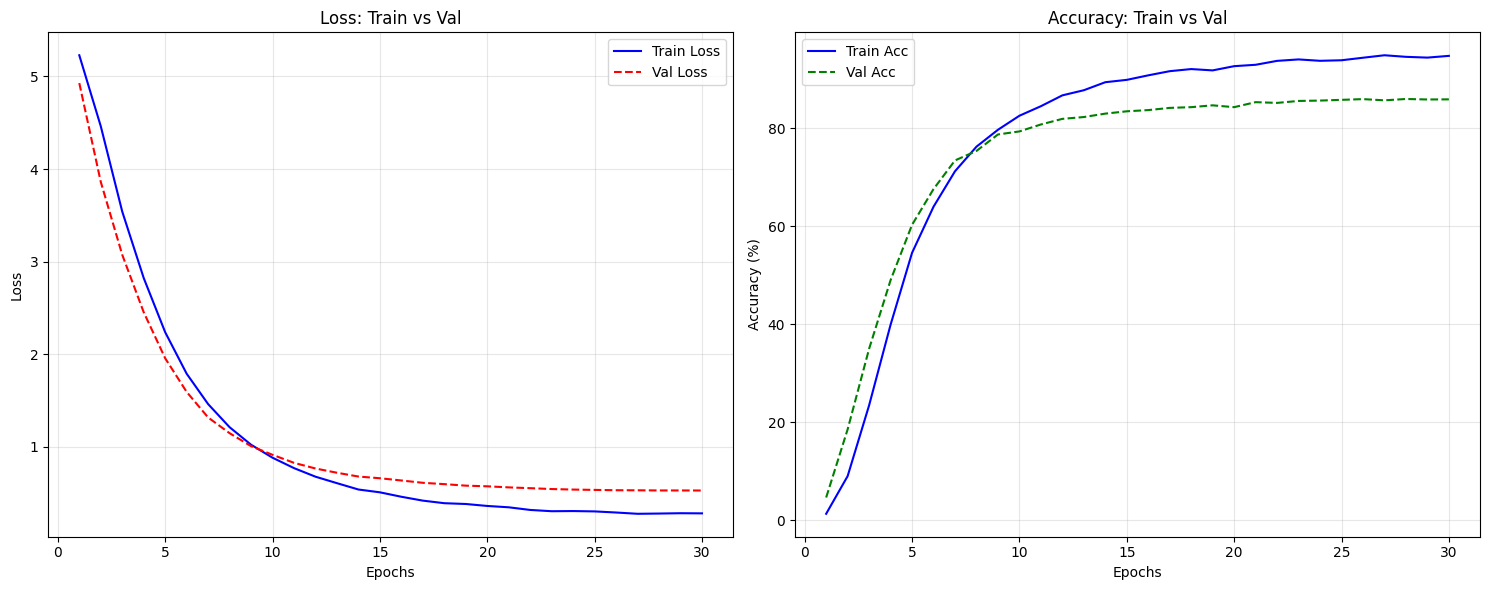

In [9]:
viz = Visualizer(save_dir="./results_visuals")
trainer = Trainer(model, train_loader, val_loader, test_loader)
history = trainer.run()
viz.plot_history(history)

In [10]:
print("\n--- Running Final Evaluation on Test ---")
trainer.model.load_state_dict(torch.load("best_vit_stanford_cars.pth"))
y_true, y_pred, y_probs = trainer.get_predictions()


--- Running Final Evaluation on Test ---



Classification Report:
              precision    recall  f1-score   support

           0     0.9565    1.0000    0.9778        22
           1     0.8400    0.9545    0.8936        22
           2     0.7500    0.7500    0.7500        16
           3     0.8333    0.9091    0.8696        22
           4     0.9474    0.8571    0.9000        21
           5     0.6818    0.7500    0.7143        20
           6     0.8095    0.8947    0.8500        19
           7     0.8095    0.7391    0.7727        23
           8     0.7778    0.7000    0.7368        20
           9     0.7500    0.7500    0.7500        16
          10     0.8421    0.8421    0.8421        19
          11     0.6522    0.7500    0.6977        20
          12     0.8333    0.7143    0.7692        21
          13     0.5714    0.8000    0.6667        20
          14     1.0000    0.7727    0.8718        22
          15     0.8333    0.8333    0.8333        18
          16     0.7917    0.8261    0.8085        23
   

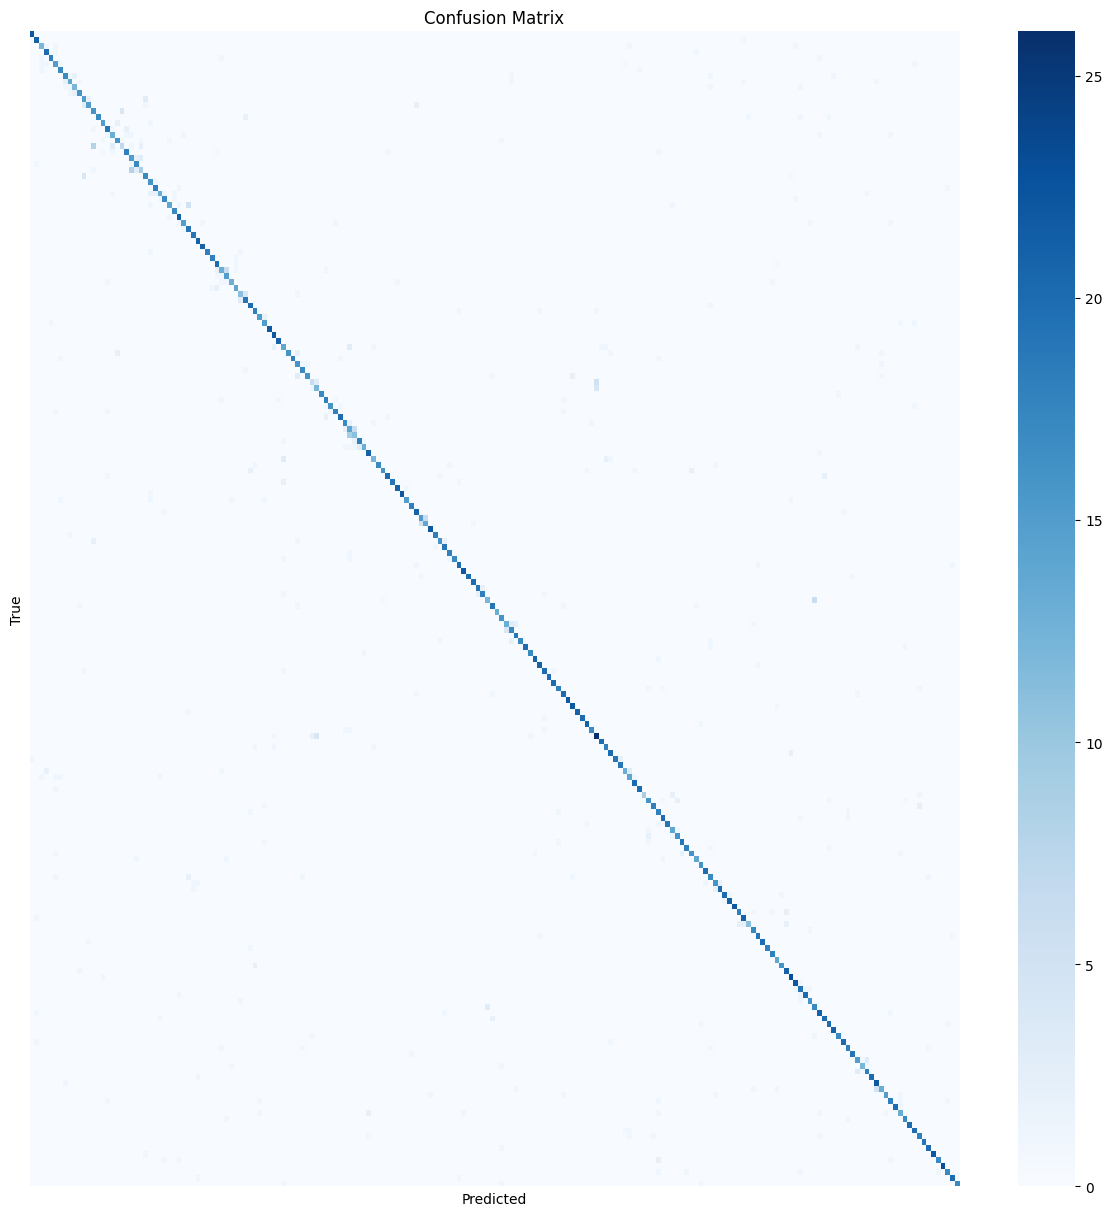

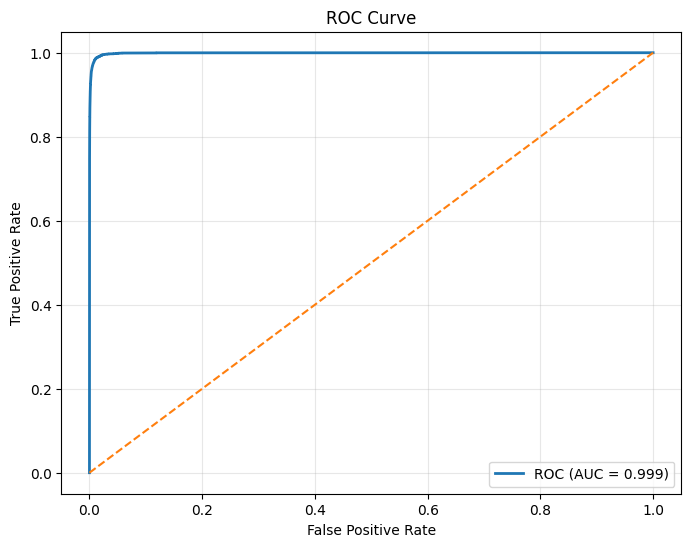

In [11]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))
viz.plot_confusion_matrix(y_true, y_pred, classes=range(n_classes))
viz.plot_roc_curve(y_true, y_probs, n_classes=n_classes)